In [1]:
import torch
import torch.nn as nn
from torch import tensor as Tensor
import matplotlib.pyplot as plt
from math import exp
import numpy as np

N = 10
Nint = 50
h = 1.0 / N
eps = -1.0
deg = 2
sigma = 10.0 * deg * deg
X = torch.linspace(0, 1, N+1)
print(X, X.dtype)

def testfunc(x, i, n):
    ''' ith test function of cell n'''
    x_mid = (X[n] + X[n+1]) / 2.0
    return 2**i * (x - x_mid)**i / (X[n+1] - X[n])** i

def grad_testfunc(x, i, n):
    ''' gradience of ith test function of cell n'''
    if i == 0:
        return 0
    else:
        x_mid = (X[n] + X[n+1]) / 2.0
        return 2**i * i * (x - x_mid)**(i-1) / (X[n+1] - X[n])** i


def source(x):
    return (4*x**3 - 4*x**2-6*x + 2) * exp(-x**2)

def exact(x):
    return (1-x)*torch.exp(-x**2)

###################################################### Particle test function ##########################################################
def particletest(r):
    '''particle test function in the nth cell, the refenece coordinate is x'''
    if r <= 1+1e-6 and r>-1e-6:
        return (1-r)**5 * (8*r**2+5*r+1)
    else:
        print("r>1, somthing went wrong!")


def grad_particletest(r):
    if r <= 1+1e-6 and r>-1e-6:
        return -14*r*(4*r+1)*(1-r)**4
    else:
        print("r>1, somthing went wrong!")

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000]) torch.float32


In [2]:
# class u(nn.Module):
#     def __init__(self, *args, **kwargs) -> None:
#         super().__init__(*args, **kwargs)
#         self.layer1 = nn.Linear(1, 10)
#         self.layer2 = nn.Linear(10, 10)
#         self.layer3 = nn.Linear(10, 1)
#     def forward(self, x):
#         o1 = torch.relu(self.layer1(x))
#         o2 = torch.relu(self.layer2(o1))
#         op = torch.relu(self.layer3(o2))
#         return op

class u(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 1)
    def forward(self, x):
        x = x[0:1]
        input = torch.cat([x, x**2])
        o1 = self.layer1(input)
        op = self.layer2(o1)
        return op

bflist = []
for _ in range(N):
    bf = u()
    bflist.append(bf)


def ref2phi(s, n):
    ''' s is the position of one dim'''
    return (s + 1) / 2.0 * (X[n+1] - X[n]) + X[n]

def phi2ref(x, n):
    xm = (X[n] + X[n+1])/2.0
    return abs(x - xm)/(- X[n] + X[n+1])*2.0 


### compute the first term in equation loss:

$$\int_{x_n}^{x_{n+1}} \nabla_x u \cdot \nabla_x v$$

And the right hand side:

$$\int_{x_n}^{x_{n+1}} fv$$

In [3]:
def computeAB(bflist, n, notf):
    s = [-0.86113631, -0.33998104, 0.33998104, 0.86113631]
    w = Tensor([0.17392742, 0.32607257, 0.32607257, 0.17392742])
    ng = w.shape[0]
    A = Tensor([0.0])
    B = Tensor([0.0])

    for k in range(ng):
        realcor = ref2phi(s[k], n)
        bf = bflist[n]
        p = Tensor([realcor], requires_grad=True)
        up = bf(p)
        gup = torch.autograd.grad(up, p, create_graph=True, retain_graph=True)[0]

        v = testfunc(p, notf, n)
        gv = grad_testfunc(p, notf, n)

        f = source(p)
        A += w[k] * (X[n+1] - X[n]) * gup * gv
        B += w[k] * (X[n+1] - X[n]) * f * v
    return A, B

print(computeAB(bflist, 3, 1))

(tensor([-0.3065], grad_fn=<AddBackward0>), tensor([-0.0104], grad_fn=<AddBackward0>))


### compute the second term in equation loss:

$$\sum_{n=0}^N\{\nabla_x u(x_n)\}[v(x_n)]$$

In [4]:

def computeC(bflist, notf):
    ''' input the list of testfunction, tell nth cell asn compute about notf_th of test function'''
    C = Tensor([0.0])

    bf0 = bflist[0]
    p0 = Tensor([0.0], requires_grad=True)
    u0 = bf0(p0)
    gu0 = torch.autograd.grad(u0, p0, retain_graph=True, create_graph=True)[0]
    v0 = testfunc(p0, notf, 0)
    # print('u0', u0)
    C -= gu0 * v0

    for n in range(1, N):
        bfl = bflist[n - 1]; bfr = bflist[n]
        p = Tensor([X[n]], requires_grad=True)

        ul = bfl(p); ur = bfr(p)
        gul = torch.autograd.grad(ul, p, create_graph=True, retain_graph=True)[0]
        gur = torch.autograd.grad(ur, p, create_graph=True, retain_graph=True)[0]

        vl = testfunc(p, notf, n - 1); vr = testfunc(p, notf, n)

        C += 0.5 * (gul + gur) * (vl - vr)
    
    bfN = bflist[N-1]
    pN = Tensor([1.0], requires_grad=True)
    uN = bfN(pN)
    guN = torch.autograd.grad(uN, pN, retain_graph=True, create_graph=True)[0]
    vN = testfunc(pN, notf, N-1)
    C += guN * vN

    return C
print(computeC(bflist, 0))


tensor([-0.3809], grad_fn=<AddBackward0>)


### compute eqloss_i
compute eqloss for every single element:

$$\int_{x_n}^{x_{n+1}}u'v'dx-u'(x_{n+1})v(x_{n+1}^-)+u'(x_n)v(x_n^+)=\int_{x_n}^{x_{n+1}}fvdx$$

In [5]:
def computeCell(bflist, n, notf):
    ''' nth cell, ith test function'''
    hn = X[n+1] - X[n]
    Cell = Tensor([0.0])
    bf = bflist[n]
    s = np.linspace(X[n], X[n+1], Nint)
    for k in range(Nint):
        p = Tensor([s[k]], requires_grad=True, dtype=torch.float32)
        # print(p)
        up = bf(p)
        gup = torch.autograd.grad(up, p, create_graph=True, retain_graph=True)[0]
        v = testfunc(p, notf, n)
        gv = grad_testfunc(p, notf, n)

        f = source(p)
        # print("gv", gup * gv, f * v)
        Cell += (gup * gv - f * v) * hn * 1.0 / Nint
        
    lp = Tensor([X[n]], requires_grad=True, dtype=torch.float32)
    rp = Tensor([X[n+1]], requires_grad=True, dtype=torch.float32)
    ul = bf(lp); ur = bf(rp)
    gul = torch.autograd.grad(ul, lp, create_graph=True, retain_graph=True)[0]
    gur = torch.autograd.grad(ur, rp, create_graph=True, retain_graph=True)[0]
    vl = testfunc(lp, notf, n)
    vr = testfunc(rp, notf, n)
    Cell += gul * vl - gur * vr
    # print("gul, gur", gul, gur)
    return Cell

# computeCell(net.models, 0, 0)

    

For symmetric:

$$\left\{\begin{aligned}
& D = \epsilon \sum_{n=0}^N\{\nabla_x v(x_n)\}[u(x_n)]\\
& E = -\epsilon \nabla_x v(x_0) u(x_0) + \epsilon \nabla_x v(x_N)u(x_N)
\end{aligned}\right.$$

In [6]:

def computeDE(bflist, notf):
    D = Tensor([0.0])
    E = Tensor([0.0])

    bf0 = bflist[0]
    p0 = Tensor([0.0], requires_grad=True)
    u0 = bf0(p0)
    gv0 = grad_testfunc(p0, notf, 0)
    leftval = 0.0
    D -= eps * gv0 * u0
    E -= eps * gv0 * leftval

    for n in range(1, N):
        bfl = bflist[n - 1]; bfr = bflist[n]
        p = Tensor([X[n]], requires_grad=True)

        ul = bfl(p); ur = bfr(p)
        
        gvl = grad_testfunc(p, notf, n-1); gvr = grad_testfunc(p, notf, n)

        D += 0.5 * eps * (gvl + gvr) * (ul - ur)
    
    bfN = bflist[N-1]
    pN = Tensor([1.0], requires_grad=True)
    uN = bfN(pN)
    gvN = grad_testfunc(pN, notf, N-1)
    rightval = 1.0
    D += eps * gvN * uN
    E + eps * gvN * rightval

    return D, E

print(computeDE(bflist, 1))


(tensor([1.5114], grad_fn=<AddBackward0>), tensor([0.], grad_fn=<SubBackward0>))


Penalty terms:
$$\left\{\begin{aligned}
& J = \sigma \sum_{n=0}^N[v(x_n)][u(x_n)]\\
& F = \sigma v(x_0) u(x_0) + \sigma v(x_N)u(x_N)
\end{aligned}\right.$$
actually its equal to bdloss and conloss

In [7]:

def computeJF(bflist, notf):
    J = Tensor([0.0])
    F = Tensor([0.0])
    bf0 = bflist[0]
    p0 = Tensor([0.0], requires_grad=True)
    u0 = bf0(p0)
    v0 = testfunc(p0, notf, 0)
    leftval = 1.0
    J += sigma * v0 * u0
    F += sigma * v0 * leftval

    for n in range(1, N):
        bfl = bflist[n - 1]; bfr = bflist[n]
        p = Tensor([X[n]], requires_grad=True)

        ul = bfl(p); ur = bfr(p)
        
        vl = testfunc(p, notf, n-1); vr = testfunc(p, notf, n)

        J += sigma * (vl - vr) * (ul - ur)
    
    bfN = bflist[N-1]
    pN = Tensor([1.0], requires_grad=True)
    uN = bfN(pN)
    gvN = grad_testfunc(pN, notf, N-1)
    rightval = 0.0
    J += sigma * gvN * uN
    F += sigma * gvN * rightval
    return J, F
print(computeJF(bflist, 1))

(tensor([-191.6464], grad_fn=<AddBackward0>), tensor([-40.], grad_fn=<AddBackward0>))


### compute Particle loss function
noted as P:

$$\sum_{k=1}^{N_{int}}w_k\left(\nabla_x u_{net}(x_k^{(i)})\cdot\nabla_r \phi_i (x_k^{(i)})
\cdot \nabla_x r(x_k^{(i)})-f(x_k^{(i)})\phi_i(x_k^{(i)})\right)$$

We note $N_{int}$ is the number of intergral points. Here we take $N_{int} = 50$

In [8]:
def computeP(bflist):
    particleloss = Tensor([0.0])
    for n in range(N):
        P = Tensor([0.0])
        hn = X[n+1] - X[n]
        bf = bflist[n]
        s = np.linspace(X[n], X[n+1], Nint, endpoint=False)
        xm = (X[n+1] + X[n]) / 2.0
        for k in range(Nint-2):
            p = Tensor([s[k]], requires_grad=True, dtype=torch.float32)
            up = bf(p)
            gup = torch.autograd.grad(up, p, create_graph=True, retain_graph=True)[0]
            r = phi2ref(s[k], n)
            # print(k, s[k], 'r', r)
            gptf = grad_particletest(r)
            if p - xm < 0:
                gr = -2.0 / hn
            else:
                gr = 2.0 / hn
            f = source(p)
            ptf = particletest(r)
            P += 1.0 / Nint * (gup * gptf * gr - f * ptf) * hn
        particleloss += P**2
    return particleloss

print(computeP(bflist))

tensor([0.0262], grad_fn=<AddBackward0>)


### compute the loss on the boundary 
$$(u(0)-1)^2 + (u(1) - 0)^2$$

In [9]:
def computebd(bflist):
    bf1 = bflist[0]; bf2 = bflist[N-1]
    bdloss = (bf1(Tensor([X[0]], requires_grad=True))- Tensor([1.0]))**2
    bdloss += (bf2(Tensor([X[N]], requires_grad=True)))**2
    return bdloss

print(computebd(bflist))

tensor([1.0888], grad_fn=<AddBackward0>)


### compute the Jump on the intersection of two intervals

$$\sum_{n=1}^{N-1}[u]^2$$

In [10]:
def computeCon(bflist):
    con = Tensor([0.0])

    for n in range(1, N):
        bfl = bflist[n - 1]; bfr = bflist[n]
        p = Tensor([X[n]], requires_grad=True)
        ul = bfl(p); ur = bfr(p)

        con += (ul - ur)**2
        # print((ul - ur)**2)
    return con

### compute the Jump of gradience on the intersection of two intervals

$$\sum_{n=1}^{N-1}[\nabla u]^2$$

In [11]:
def computeGradCon(bflist):
    gcon = Tensor([0.0])

    for n in range(1, N):
        bfl = bflist[n - 1]; bfr = bflist[n]
        p = Tensor([X[n]], requires_grad=True)
        ul = bfl(p); ur = bfr(p)
        gul = torch.autograd.grad(ul, p, retain_graph=True, create_graph=True)[0]
        gur = torch.autograd.grad(ur, p, retain_graph=True, create_graph=True)[0]
        gcon += (gul - gur)**2
    return gcon

print(computeGradCon(bflist))

tensor([1.2627], grad_fn=<AddBackward0>)


In [12]:
class DGNet1:
    def __init__(self) -> None:
        bflist = []
        for _ in range(N):
            bf = u()
            bflist.append(bf)
        self.models = bflist
        self.parameters = aggpara(self.models)
        self.optimizer = torch.optim.Adam(self.parameters, lr=1.0)
        self.maxIter = 1000
        self.iter = 1
    
    def loss(self):
        # tfloss = torch.zeros((deg, 1))
        # for i in range(deg):
        #     tfloss[i] = Tensor([0.0])
        #     for k in range(N):
        #         A, B = computeAB(self.models, k, i)
        #         tfloss[i] += A - B
        #     C = computeC(self.models, i)
        #     D, E = computeDE(self.models, i)
        #     J, F = computeJF(self.models, i)
        #     tfloss[i] -= C
        #     tfloss[i] += D - E
        #     tfloss[i] += J - F
        # loss = torch.sum(tfloss ** 2)
        
        ########################### particle loss ###############################


        particleloss = 2.0 * computeP(self.models) / N
        conloss = computeCon(self.models) 
        bdloss = computebd(self.models) / 2
        gconloss = computeGradCon(self.models) 

        loss = particleloss + bdloss + conloss + gconloss
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(f"The {self.iter}th training, loss is {loss.item()}: paricleloss is {particleloss.item()}, conloss is {conloss.item()}, bdloss is {bdloss.item()}, gconloss is {gconloss.item()}")
        return loss
    
    def train(self, niter):
        trainplug(self.models)
        for _ in range(niter):
            self.optimizer.zero_grad()
            loss = self.loss()
            if loss < 1e-4:
                print(f"The {self.iter}th training, loss is {loss.item()}")
                break
            loss.backward()
            self.optimizer.step()


class DGNet:
    def __init__(self) -> None:
        bflist = []
        for _ in range(N):
            bf = u()
            bflist.append(bf)
        self.models = bflist
        self.parameters = aggpara(self.models)
        self.optimizer = torch.optim.LBFGS(self.parameters, lr=1.0, max_iter=50000, max_eval=50000, history_size=50, 
                                           tolerance_grad=1e-7, tolerance_change=1.0 * np.finfo(float).eps, line_search_fn='strong_wolfe')
        self.maxIter = 1000
        self.iter = 1
    
    def loss1(self):
        self.optimizer.zero_grad()
        ########################### dgloss ####################################
        tfloss = torch.zeros((deg + 1, 1))
        for i in range(deg + 1):
            for k in range(N):
                A = computeCell(self.models, k, i)
                tfloss[i] += A ** 2
        dgloss = torch.sum(tfloss).unsqueeze(0)
        loss = dgloss

        conloss = computeCon(self.models) 
        bdloss = computebd(self.models) / 2
        gconloss = computeGradCon(self.models) 

        loss += bdloss + conloss + gconloss
        loss.backward()
        self.iter += 1
        if self.iter % 10 == 0:
            print(f"The {self.iter}th training, loss is {loss.item()}: dgloss is {dgloss.item()}, conloss is {conloss.item()}, bdloss is {bdloss.item()}, gconloss is {gconloss.item()}")
        
        return loss

    def loss2(self):
        self.optimizer.zero_grad()
        tfloss = torch.zeros((deg + 1, 1))
        for i in range(deg + 1):
            for k in range(N):
                A = computeCell(self.models, k, i)
                tfloss[i] += A
            D, E = computeDE(self.models, i)
            tfloss[i] += D - E
            # print(i, tfloss[i])
        dgloss = torch.sum(tfloss ** 2).unsqueeze(0)
        loss = dgloss

        conloss = computeCon(self.models) 
        bdloss = computebd(self.models) / 2
        gconloss = computeGradCon(self.models) 

        # loss =  particleloss + bdloss + conloss + gconloss
        loss += bdloss + conloss + gconloss
        loss.backward()
        self.iter += 1
        # if self.iter % 10 == 0:
        #     print(f"The {self.iter}th training, loss is {loss.item()}: paricleloss is {particleloss.item()}, conloss is {conloss.item()}, bdloss is {bdloss.item()}, gconloss is {gconloss.item()}")
        if self.iter % 10 == 0:
            print(f"The {self.iter}th training, loss is {loss.item()}: dgloss is {dgloss.item()}, conloss is {conloss.item()}, bdloss is {bdloss.item()}, gconloss is {gconloss.item()}")
        
        return loss

    def loss(self):
        self.optimizer.zero_grad()

        ########################### particle loss ###############################
        particleloss = 2.0 * computeP(self.models) / N

        ########################### constraint loss #############################
        conloss = computeCon(self.models) 
        bdloss = computebd(self.models) / 2
        gconloss = computeGradCon(self.models) 

        loss =  particleloss + bdloss + conloss + gconloss
        loss.backward()
        self.iter += 1
        if self.iter % 10 == 0:
            print(f"The {self.iter}th training, loss is {loss.item()}: paricleloss is {particleloss.item()}, conloss is {conloss.item()}, bdloss is {bdloss.item()}, gconloss is {gconloss.item()}")
        
        return loss
    
    def train(self):
        trainplug(self.models)
        self.optimizer.step(self.loss2)


def aggpara(bflist):
    parameters = list()
    for i in range(N):
        parameters += list(bflist[i].parameters())
    return parameters
def trainplug(bflist):
    for i in range(N):
        bflist[i].train()
def evalplug(bflist):
    for i in range(N):
        bflist[i].eval()

In [13]:
net = DGNet()
net.train()

The 10th training, loss is 0.8788052797317505: dgloss is 0.8788052797317505, conloss is 0.13360215723514557, bdloss is 0.40805700421333313, gconloss is 0.11535589396953583
The 20th training, loss is 0.4832393527030945: dgloss is 0.4832393527030945, conloss is 0.06589092314243317, bdloss is 0.29965412616729736, gconloss is 0.026369154453277588
The 30th training, loss is 0.3713478147983551: dgloss is 0.3713478147983551, conloss is 0.0653337836265564, bdloss is 0.26622965931892395, gconloss is 0.023611657321453094
The 40th training, loss is 0.3356625437736511: dgloss is 0.3356625437736511, conloss is 0.04792729392647743, bdloss is 0.281269371509552, gconloss is 0.0064345127902925014
The 50th training, loss is 0.3313148617744446: dgloss is 0.3313148617744446, conloss is 0.04870624467730522, bdloss is 0.27905353903770447, gconloss is 0.00344366068020463
The 60th training, loss is 0.3282380998134613: dgloss is 0.3282380998134613, conloss is 0.051771461963653564, bdloss is 0.27561235427856445

In [19]:
print(computeCell(net.models, 1, 2))

jj = Tensor([0.0])
for i in range(N):
    a = computeCell(net.models, i, 2)
    jj += a
print(jj)

tensor([-0.0037], grad_fn=<AddBackward0>)
tensor([0.0227], grad_fn=<AddBackward0>)


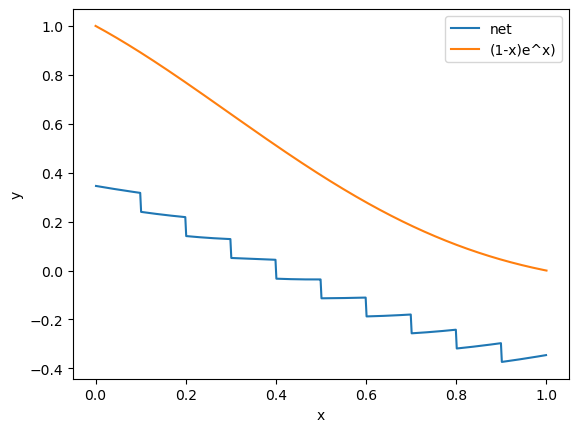

In [14]:
import matplotlib.pyplot as plt  
import numpy as np

bfl = net.models

def sol(n):
    x = torch.linspace(-1, 1, 100)[1:-1]
    xreal = torch.zeros_like(x)
    y = torch.zeros_like(x)
    for i in range(x.shape[0]):
        xreal[i] = ref2phi(x[i], n)
        y[i] = bfl[n](Tensor([xreal[i]]))
    return xreal, y

def tforigin(notf, n):
    x = torch.linspace(-1, 1, 100)[1:-1]
    xreal = torch.zeros_like(x)
    y = torch.zeros_like(x)
    for i in range(x.shape[0]):
        xreal[i] = ref2phi(x[i], n)
        y[i] = testfunc(Tensor([xreal[i]]), notf , n)
    return xreal, y

################################ plot the solution ####################################
XX = torch.tensor([])  
YY = torch.tensor([]) 
for i in range(N):
    xreal, y = sol(i)
    XX = torch.cat((XX, xreal), dim=0)
    YY = torch.cat((YY, y), dim=0)
XX = XX.detach().numpy()
YY = YY.detach().numpy()
plt.plot(XX, YY, label='net')
plt.xlabel('x') 
plt.ylabel('y') 

################################# plot test function ###################################
# for notf in range(3):
#     TF = torch.tensor([]) 
#     for i in range(N):
#         _, y = tforigin(notf, i)
#         TF = torch.cat((TF, y), dim=0)
#     TF = TF.detach().numpy()
#     plt.plot(XX, TF, label=f'tf{notf}')
    

################################# plot exact solution ###################################
x_values = np.linspace(0, 1, 1000)  # 生成 x 值  
y_values = (1 - x_values) * np.exp(-x_values**2)  # 计算对应的 y 值  
plt.plot(x_values, y_values, label='(1-x)e^x)')  


plt.xlabel('x')  
plt.ylabel('y')  
plt.legend() 
plt.show() 